In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

MODEL_NAME = "ProsusAI/finbert"
device = 0 if torch.cuda.is_available() else -1  # 0=GPU, -1=CPU

tok = AutoTokenizer.from_pretrained(MODEL_NAME)
mdl = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
clf = pipeline("text-classification", model=mdl, tokenizer=tok, device=device, truncation=True)
print("Using device:", "GPU" if device==0 else "CPU")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Device set to use cuda:0


Using device: GPU


In [ ]:
import pandas as pd

# GANTI path kalau beda
df = pd.read_csv("clean_link_emirates.csv")

# pilih kolom teks utama (prioritas lemmatized)
text_col_candidates = ["text_lemmatized", "text_after_stop", "content_nopunct", "cleaned_text", "konten", "content"]
text_col = next((c for c in text_col_candidates if c in df.columns), None)
print("Pakai kolom teks:", text_col)


Pakai kolom teks: text_lemmatized


In [ ]:
import numpy as np
from tqdm import tqdm

def chunk_text_by_words(text, max_words=220):
    words = str(text).split()
    if not words:
        return []
    return [" ".join(words[i:i+max_words]) for i in range(0, len(words), max_words)]

def predict_article(text):
    chunks = chunk_text_by_words(text, max_words=220)
    if not chunks:
        return {"label":"neutral","score":0.0,"pos":0.0,"neu":1.0,"neg":0.0,"n_chunks":0}

    all_outputs = []
    for chunk in chunks:
        out = clf(chunk, top_k=None)  # run pipeline per chunk
        all_outputs.append(out)

    # kumpulkan skor per label
    scores = {"positive":[],"neutral":[],"negative":[]}
    for chunk_out in all_outputs:
        chunk_out = chunk_out if isinstance(chunk_out,list) else [chunk_out]
        for it in chunk_out:
            scores[it["label"].lower()].append(it["score"])

    avg = {k: float(np.mean(v)) if v else 0.0 for k,v in scores.items()}
    label = max(avg, key=avg.get)
    return {"label":label, "score":avg[label], "pos":avg["positive"], "neu":avg["neutral"], "neg":avg["negative"], "n_chunks":len(chunks)}


In [ ]:
tqdm.pandas()
preds = df[text_col].progress_apply(predict_article)

df["sentiment_label"] = preds.apply(lambda x: x["label"])
df["sentiment_score"] = preds.apply(lambda x: x["score"])
df["sent_pos"] = preds.apply(lambda x: x["pos"])
df["sent_neu"] = preds.apply(lambda x: x["neu"])
df["sent_neg"] = preds.apply(lambda x: x["neg"])
df["n_chunks"] = preds.apply(lambda x: x["n_chunks"])

df.head()



  3%|▎         | 5/150 [00:00<00:18,  8.00it/s]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset

100%|██████████| 150/150 [00:06<00:00, 22.27it/s]


,url,title,date,content_raw,content_lower,content_nopunct,text_before_stop,text_after_stop,text_lemmatized,wc_raw,wc_nopunct,wc_before,wc_after,sentiment_label,sentiment_score,sent_pos,sent_neu,sent_neg,n_chunks
0,https://www.emirates.com/media-centre/the-emir...,"‘The Emirates App’ now launches on iPhone, ope...",2014-11-16,"Dubai, UAE, 16 November 2014 – Building on the...",dubai uae 16 november 2014 – building on the s...,dubai uae november building on the s...,dubai uae 16 november 2014 – building on the s...,dubai uae november building successful launch ...,dubai uae november building successful launch ...,432,432,444,265,neutral,0.907703,0.074261,0.907703,0.018037,2
1,https://www.emirates.com/media-centre/emirates...,"Emirates expands its mobile footprint, launche...",2015-05-18,The Emirates App now available on the world’s ...,the emirates app now available on the world’s ...,the emirates app now available on the world s ...,the emirates app now available on the world ’ ...,emirates app available world largest mobile pl...,emirate app available world large mobile platf...,451,456,466,265,neutral,0.835481,0.151874,0.835481,0.012645,2
2,https://www.emirates.com/media-centre/emirates...,Emirates app hits 20 million downloads with st...,2020-03-04,"Dubai, UAE, 21 May 2019 – All the features in ...",dubai uae 21 may 2019 – all the features in th...,dubai uae may all the features in th...,dubai uae 21 may 2019 – all the features in th...,dubai uae may features emirates app available ...,dubai uae may feature emirate app available ar...,454,452,470,276,neutral,0.799583,0.188516,0.799583,0.011901,2
3,https://www.emirates.com/media-centre/emirates...,Emirates forges partnerships with Internationa...,2025-04-30,"Dubai, UAE, 30 April 2025: Emirates has forged...",dubai uae 30 april 2025 emirates has forged ne...,dubai uae april emirates has forged ne...,dubai uae 30 april 2025 emirates has forged ne...,dubai uae april emirates forged new partnershi...,dubai uae april emirate forge new partnership ...,645,653,670,430,neutral,0.829995,0.157790,0.829995,0.012215,2
4,https://www.executivetraveller.com/emirates-la...,Emirates launches iPhone app,2014-11-17,"Emirates passengers can now book flights, chec...",emirates passengers can now book flights check...,emirates passengers can now book flights check...,emirates passengers can now book flights check...,emirates passengers book flights check go keep...,emirate passenger book flight check go keep ey...,182,187,196,103,neutral,0.893911,0.092244,0.893911,0.013845,1


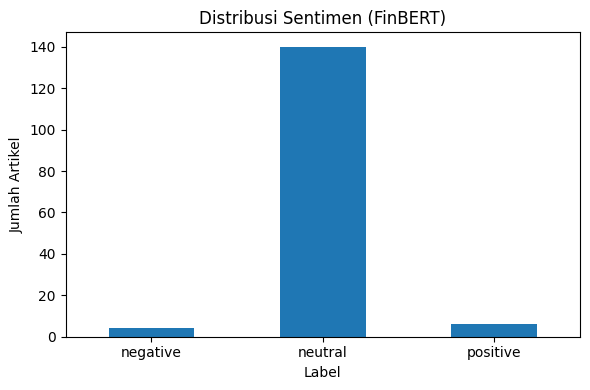

In [ ]:
import matplotlib.pyplot as plt

dist = df["sentiment_label"].value_counts().reindex(["negative","neutral","positive"]).fillna(0)
dist.plot(kind="bar", figsize=(6,4), rot=0, title="Distribusi Sentimen (FinBERT)")
plt.xlabel("Label")
plt.ylabel("Jumlah Artikel")
plt.tight_layout()
plt.show()


In [ ]:
dist = df["sentiment_label"].value_counts().reindex(["positive","neutral","negative"]).fillna(0)
total = dist.sum()
(dist / total * 100).round(2)


,count
sentiment_label,
positive,4.00
neutral,93.33
negative,2.67


In [ ]:
out_csv = "/content/sentiment_results_finbert.csv"
df.to_csv(out_csv, index=False)
print("✅ Hasil disimpan di:", out_csv)


✅ Hasil disimpan di: /content/sentiment_results_finbert.csv


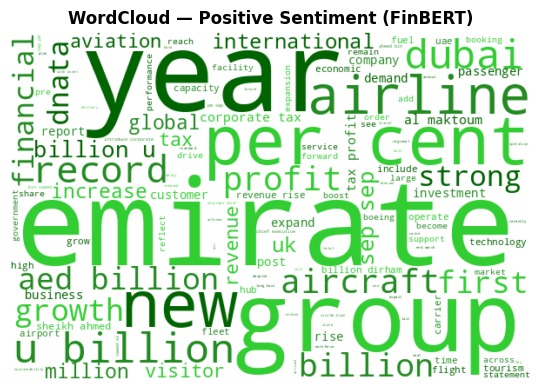

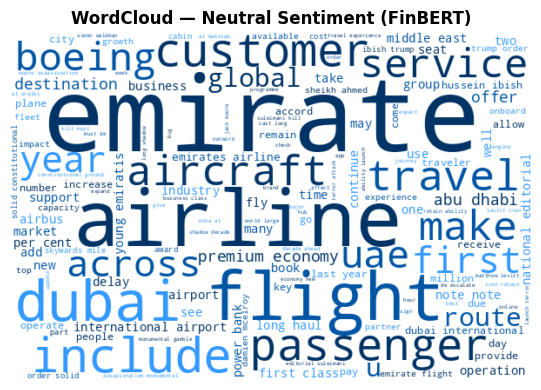

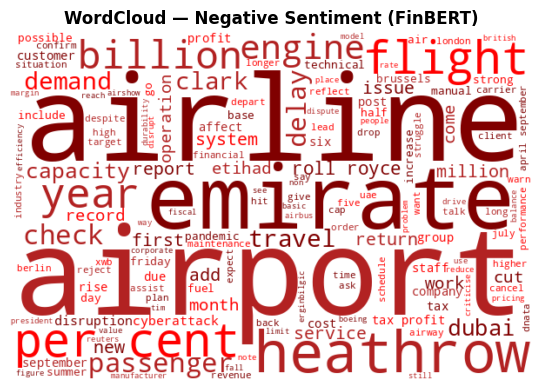

In [ ]:
color_maps = {
    "positive": ["#006400", "#228B22", "#32CD32"],  # hijau tua
    "neutral": ["#003366", "#0055A4", "#3399FF"],   # biru kontras
    "negative": ["#800000", "#B22222", "#FF0000"]   # merah pekat
}

from random import choice
def color_func_factory(palette):
    def color_func(*args, **kwargs):
        return choice(palette)
    return color_func

for label in ["positive", "neutral", "negative"]:
    text = " ".join(df[df["sentiment_label"] == label]["text_lemmatized"].dropna().astype(str))
    wc = WordCloud(
        width=600,
        height=400,
        background_color="white",
        max_words=150,
        color_func=color_func_factory(color_maps[label])
    ).generate(text)

    plt.figure(figsize=(6,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud — {label.capitalize()} Sentiment (FinBERT)", fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.show()


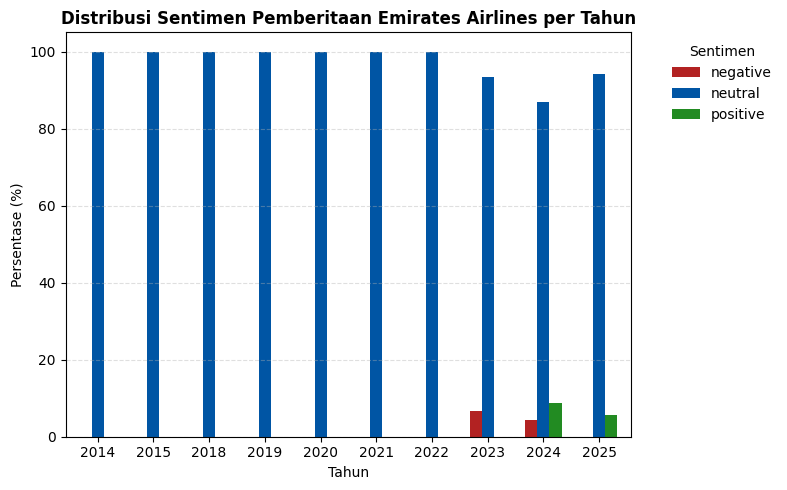

In [ ]:
import matplotlib.pyplot as plt

# pastikan kolom 'year' integer & diurutkan
df["year"] = pd.to_datetime(df["date"], errors="coerce").dt.year.astype("Int64")
sent_by_year = pd.crosstab(df["year"], df["sentiment_label"], normalize="index") * 100
sent_by_year = sent_by_year.sort_index()

# pastikan urutan kolom sesuai urutan warna
sent_by_year = sent_by_year[["negative", "neutral", "positive"]]

# warna sesuai WordCloud
colors = {"negative": "#B22222", "neutral": "#0055A4", "positive": "#228B22"}

# buat bar chart (tanpa outline & lebih lebar)
ax = sent_by_year.plot(
    kind="bar",
    stacked=False,       # ubah ke True kalau mau stacked chart
    color=[colors[c] for c in sent_by_year.columns],
    figsize=(8,5),
    width=0.65,          # biar batang lebih tebal
)

plt.title("Distribusi Sentimen Pemberitaan Emirates Airlines per Tahun", fontsize=12, fontweight="bold")
plt.xlabel("Tahun")
plt.ylabel("Persentase (%)")
plt.xticks(range(len(sent_by_year.index)), [str(y) for y in sent_by_year.index], rotation=0)
plt.legend(title="Sentimen", bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()
